# Economo et al., 2018 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Michael N. Economo, Sarada Viswanathan, Bosiljka Tasic, Erhan Bas, Johan Winnubst, Vilas Menon, Lucas T. Graybuck,Thuc Nghi Nguyen, Kimberly A. Smith, Zizhen Yao, Lihua Wang, Charles R. Gerfen, Jayaram Chandrashekar, Hongkui Zeng, Loren L. Looger & Karel Svoboda. "Distinct descending motor cortex
pathways and their roles in movement" (2018) Nature (https://doi.org/10.1038/s41586-018-0642-9)

The study identified two types of pyramidal track (PT) neuron in the mouse motor cortex, referred to as PT<sub>upper</sub> and PT<sub>lower</sub>. Further investigation using extracellular recordings in the anterior lateral motor cortex (ALM) during a delay-response task, the study revealed specialized roles for the two neuron types: i) PT<sub>upper</sub> neurons are preferentially involed in motor planning, ii) PT<sub>lower</sub> neurons are more involved in movement execution.  

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to ***NWB 2.0*** format is also available.

## About the data

The dataset comprises of extracellular recordings and spike sorted results of the mouse's ALM during a delay-response task. The behavior data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response, etc.) and the timing of the lick events (e.g. lick left, lick right onset). 

Original data is publically available at: doi: 10.25378/janelia.7007846

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. 

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [1]:
# import necessary Python packages including DataJoint

from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

import datajoint as dj
from pipeline import (reference, subject, acquisition, analysis,
                      extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


## The architecture of the data pipeline

This data pipeline is comprised of three core components:
+ **subject**: tables for meta information, including subjects and their genetic information, actions on the subjects.
+ **acquisition**: tables to capture the workflow of the experiment, including Sessions, Behavior Trials, different experimental events (e.g. sample, delay, response periods)
+ **extracellular**: tables to capture the extracellular data and clustering results (e.g. units and spike times)

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

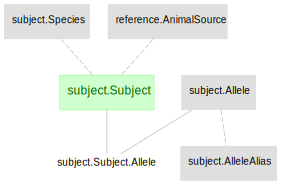

In [23]:
dj.Diagram(subject) - 1 

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [5]:
subject.Subject()

subject_id id of the subject (e.g. ANM244028),species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm369962,Mus musculus,N/A,U,None,None
anm369963,Mus musculus,N/A,U,None,None
anm369964,Mus musculus,N/A,U,None,None
anm372793,Mus musculus,N/A,U,None,None
anm372794,Mus musculus,N/A,U,None,None
anm372795,Mus musculus,N/A,U,None,None
anm372797,Mus musculus,N/A,U,None,None


### Acquisition and behavior

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

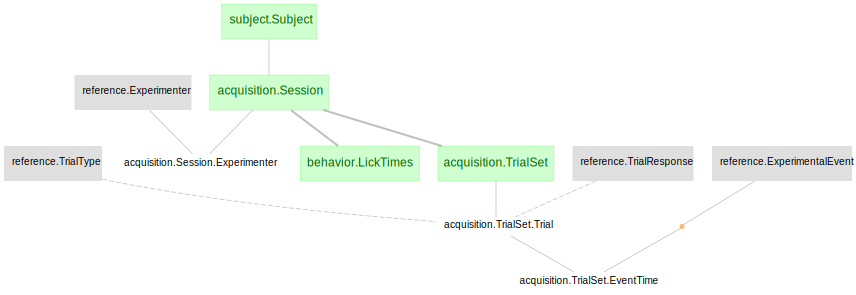

In [19]:
dj.Diagram(acquisition) - 1 + dj.Diagram(behavior)

`Session` tables contains information about individual experiment session.

In [24]:
acquisition.Session * subject.Subject

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,session_directory,session_note,species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm369962,2017-03-09 00:00:00,0,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-10 00:00:00,1,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-13 00:00:00,0,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-14 00:00:00,1,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-15 00:00:00,2,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-16 00:00:00,3,,,Mus musculus,N/A,U,None,None
anm369962,2017-03-17 00:00:00,4,,,Mus musculus,N/A,U,None,None


### Extracellular

Information related to extracellular electrophysiology is captured in the `extracellular` schema, including: probe, probe insertion location, unit, spikes, etc.

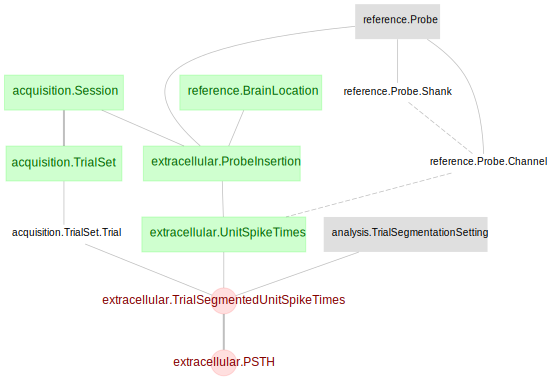

In [17]:
dj.Diagram(extracellular) - 1

As an example, we can query and display the `extracellular.UnitSpikeTimes` table for all neurons, exclude neuron type of "unidentified"

In [26]:
extracellular.UnitSpikeTimes & 'unit_cell_type != "unidentified"'

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,probe_name String naming probe model,channel_counts number of channels in the probe,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,insertion_depth (um),unit_id,channel_id id of a channel on the probe,unit_cell_type depending on the animal (which cell-type being tagged),unit_quality,unit_depth (um),"spike_times (s) time of each spike, with respect to the start of session"
anm369962,2017-03-09 00:00:00,0,H-129,64,ALM,N/A,5,left,1225.00,1001,24,PTlower,Excellent,1005.0,=BLOB=
anm369962,2017-03-09 00:00:00,0,H-129,64,ALM,N/A,5,left,1225.00,1002,45,PTlower,Good,730.0,=BLOB=
anm369962,2017-03-09 00:00:00,0,H-129,64,ALM,N/A,5,left,1225.00,1003,55,PTlower,Good,980.0,=BLOB=
anm369962,2017-03-10 00:00:00,1,H-129,64,ALM,N/A,5,right,1260.00,1001,48,PTlower,Excellent,840.0,=BLOB=
anm369962,2017-03-10 00:00:00,1,H-129,64,ALM,N/A,5,right,1260.00,1002,50,PTlower,Excellent,890.0,=BLOB=
anm369962,2017-03-10 00:00:00,1,H-129,64,ALM,N/A,5,right,1260.00,1003,49,PTlower,Good,865.0,=BLOB=
anm369962,2017-03-10 00:00:00,1,H-129,64,ALM,N/A,5,right,1260.00,1004,52,PTlower,Excellent,940.0,=BLOB=


### The entirety of the ***DataJoint*** pipeline for this study is captured in the figure below

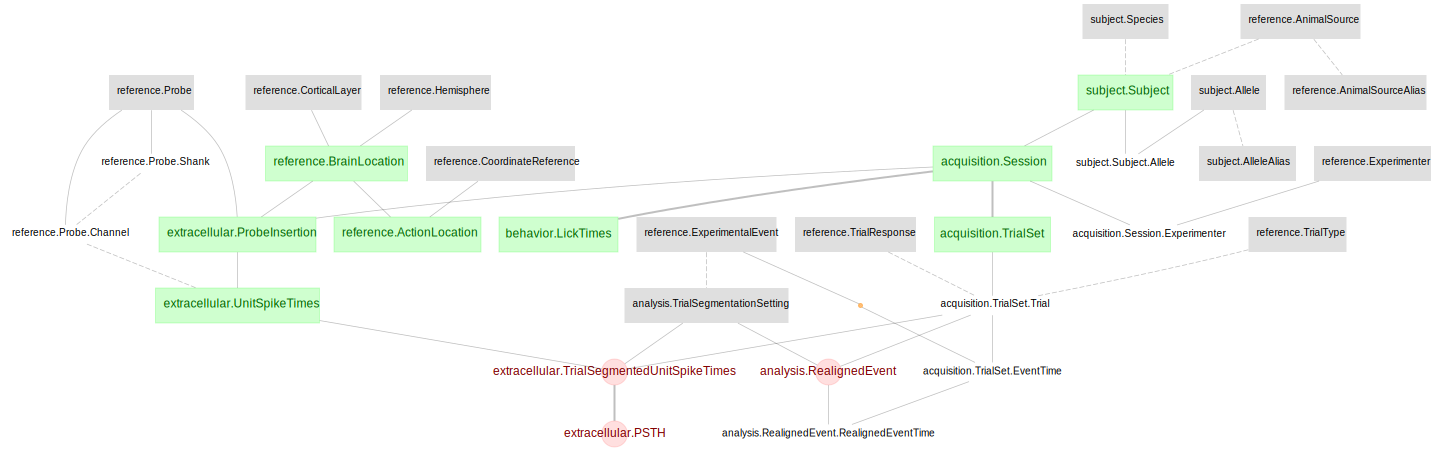

In [13]:
all_erd = (dj.Diagram(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis) 
           + dj.ERD(behavior) + dj.ERD(extracellular))
all_erd

## Reproduced analysis and figures

To demonstrate the availability and usage of the data in the pipeline, we will go through the steps to reproduce the ***Extended Data Figure 5***.

The ***Extended Data Figure 5*** presented the inter-spike interval histograms and trial-averaged activity on lick-right and lick-left trials, time locked to the onset of `cue start` event (denotes the onset of the *response* period).  

The following sections describe the steps taken to reproduce this figure:
+ Query, pool the applicable subset of the data
+ Conditioning/restructure the extracted data
+ Build plotting functions
+ Plot

## Query the data of interest

Here we will make several queries and extractions of the subset of data, based on several criteria

#### Queries of unit spike times and inter-spike interval, categorized by:
+ Cell type: PT<sub>upper</sub> vs. PT<sub>lower</sub>
+ Trial type: left-lick vs. right-lick
+ Hemisphere: left (contralateral to injection site) vs. right (ipsilateral to injection site)

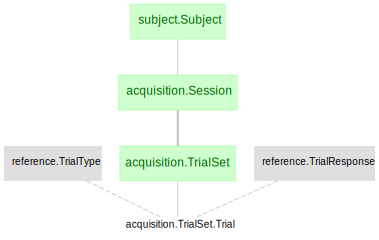

In [12]:
dj.Diagram(acquisition.TrialSet.Trial) - 1 + acquisition.Session + subject.Subject

The trial-type selection: left-lick vs right-lick

In [3]:
leftlick_trial = {'trial_type': 'lick left', 'trial_is_good': True, 'trial_response': 'correct'}
rightlick_trial = {'trial_type': 'lick right', 'trial_is_good': True, 'trial_response': 'correct'}

The PT<sub>upper</sub> and PT<sub>lower</sub> neuron selection, per hemisphere

In [4]:
# limit selection of unit to types: "Excellent", "Good", and "Single"
good_units_filt = ['unit_quality="Excellent"', 'unit_quality="Good"', 'unit_quality="Single"']

# query left-hemisphere PTupper and PTlower units
lh_PTupper_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTupper"'
                    & 'hemisphere="left"' & good_units_filt)
lh_PTlower_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTlower"'
                    & 'hemisphere="left"' & good_units_filt)

# query right-hemisphere PTupper and PTlower units
rh_PTupper_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTupper"'
                    & 'hemisphere="right"' & good_units_filt)
rh_PTlower_units = (extracellular.UnitSpikeTimes & 'unit_cell_type="PTlower"'
                    & 'hemisphere="right"' & good_units_filt)

Check the number of units found for each group.

In [5]:
print(f'Left-ALM PTupper unit counts: {len(lh_PTupper_units)}')
print(f'Left-ALM PTlower unit counts: {len(lh_PTlower_units)}')
print(f'Right-ALM PTupper unit counts: {len(rh_PTupper_units)}')
print(f'Right-ALM PTlower unit counts: {len(rh_PTlower_units)}')

Left-ALM PTupper unit counts: 65
Left-ALM PTlower unit counts: 46
Right-ALM PTupper unit counts: 0
Right-ALM PTlower unit counts: 32


### Visualize some tables

Let's look at the queried table of all left-hemisphere, **PT<sub>upper</sub>** units

In [6]:
lh_PTupper_units

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,probe_name String naming probe model,channel_counts number of channels in the probe,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,insertion_depth (um),unit_id,channel_id id of a channel on the probe,unit_cell_type depending on the animal (which cell-type being tagged),unit_quality,unit_depth (um),"spike_times (s) time of each spike, with respect to the start of session"
anm372793,2017-05-04 00:00:00,0,H-129,64,ALM,N/A,5,left,1100.00,1001,38,PTupper,Good,430.0,=BLOB=
anm372793,2017-05-05 00:00:00,1,H-116,64,ALM,N/A,5,left,1100.00,1001,11,PTupper,Good,555.0,=BLOB=
anm372793,2017-05-05 00:00:00,1,H-116,64,ALM,N/A,5,left,1100.00,1002,17,PTupper,Excellent,705.0,=BLOB=
anm372793,2017-05-05 00:00:00,1,H-116,64,ALM,N/A,5,left,1100.00,1003,51,PTupper,Excellent,755.0,=BLOB=
anm372793,2017-05-08 00:00:00,2,H-116,64,ALM,N/A,5,left,1150.00,1001,17,PTupper,Good,755.0,=BLOB=
anm372793,2017-05-11 00:00:00,3,H-116,64,ALM,N/A,5,left,1100.00,1001,8,PTupper,Good,480.0,=BLOB=
anm372793,2017-05-11 00:00:00,3,H-116,64,ALM,N/A,5,left,1100.00,1002,14,PTupper,Good,630.0,=BLOB=


Queried table of all **left lick** trials with recording on left-hemisphere, **PT<sub>upper</sub>** units

In [7]:
acquisition.TrialSet.Trial & lh_PTupper_units & leftlick_trial

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to the starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,trial_is_good good/bad status of trial (bad trials are not analyzed)
anm372793,2017-05-04 00:00:00,0,3,355.459,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,4,361.859,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,6,374.659,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,10,400.259,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,18,451.458,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,19,457.858,lick left,correct,0,1
anm372793,2017-05-04 00:00:00,0,20,464.258,lick left,correct,0,1


All the events of the first **left lick** trials of each session for all sessions

In [8]:
acquisition.TrialSet.EventTime & (acquisition.TrialSet.Trial & leftlick_trial & 'trial_id=1')

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,trial_id id of this trial in this trial set,trial_event,event_time (in second) event time with respect to this session's start time
anm369962,2017-03-09 00:00:00,0,1,cue_start,6.37397
anm369962,2017-03-09 00:00:00,0,1,pole_in,3.87349
anm369962,2017-03-09 00:00:00,0,1,pole_out,4.87365
anm369963,2017-02-27 00:00:00,1,1,cue_start,51.229
anm369963,2017-02-27 00:00:00,1,1,pole_in,48.7283
anm369963,2017-02-27 00:00:00,1,1,pole_out,49.7285
anm369964,2017-03-20 00:00:00,0,1,cue_start,6.96214


## Extract the trial-aligned spike sorted data

Now that we have the queries specific to the trial of interest and neuron of interest, we can extract the sorted spike times data, per cell, trial-aligned to the *response* period. 

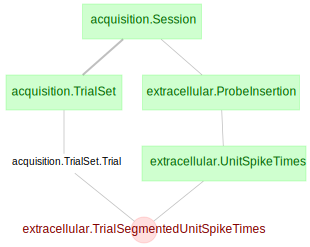

In [7]:
dj.Diagram(extracellular.UnitSpikeTimes) + acquisition.TrialSet.Trial + acquisition.Session + extracellular.TrialSegmentedUnitSpikeTimes

Next, select a particuclar setting defining how to segment out information per trial, including the definition of even for alignment

here we choose segmentation setting to align to `cue-onset` event

In [9]:
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start'}).fetch1()

#### Extracting the trial-aligned unit spike times

To this end, we now build a function to extract (`.fetch()`) from the data pipeline the spike-times per unit, with the above trial and neuron criteria applied

Per unit, perform:
+ extract spike-times and PSTH for all trials for left-lick and right-lick
+ compute inter-spike intervals for all spikes in all trials
+ exclude results with less than 50 correct trial-repsonse

In [10]:
# per unit, extract spike-times and psth
correct_trial_count_thresh = 50  # 50 correct trial of each left/right type
def get_psth_isi(unit_key):
    l_spks, l_psths = (extracellular.TrialSegmentedUnitSpikeTimes * extracellular.PSTH & unit_key & seg_param_key 
                       & (acquisition.TrialSet.Trial & leftlick_trial)).fetch('segmented_spike_times', 'psth')
    r_spks, r_psths = (extracellular.TrialSegmentedUnitSpikeTimes * extracellular.PSTH & unit_key & seg_param_key
                       & (acquisition.TrialSet.Trial & rightlick_trial)).fetch('segmented_spike_times', 'psth')
    
    if len(l_spks) < correct_trial_count_thresh or len(r_spks) < correct_trial_count_thresh:
        return None
            
    out = dict(isi=np.hstack(np.diff(spk) for spk in np.hstack([l_spks, r_spks])), 
               l_psth=np.nanmean(np.vstack(psth for psth in l_psths), axis=0),
               r_psth=np.nanmean(np.vstack(psth for psth in r_psths), axis=0))
    
    # Query event times (e.g. sample-start, delay-start, etc.)
    events, event_times = (analysis.RealignedEvent.RealignedEventTime & seg_param_key & unit_key &
                          (acquisition.TrialSet.Trial & {'trial_response': 'correct'})).fetch(
        'trial_event', 'realigned_event_time')
    # Calculate mean event times across trials
    out['mean_event_times'] = {name: np.nanmedian([t for n, t in zip(events, event_times) if n == name]) for name in set(events)}

    return out

In [11]:
lh_PTupper_units_psth = [v for v in [get_psth_isi(u) for u in lh_PTupper_units] if v]
lh_PTlower_units_psth = [v for v in [get_psth_isi(u) for u in lh_PTlower_units] if v]
rh_PTupper_units_psth = [v for v in [get_psth_isi(u) for u in rh_PTupper_units] if v]
rh_PTlower_units_psth = [v for v in [get_psth_isi(u) for u in rh_PTlower_units] if v]

Quickly check how many units of each group passed the selection criteria above

In [12]:
print(f'Left-ALM PTupper unit counts: {len(lh_PTupper_units_psth)}')
print(f'Left-ALM PTlower unit counts: {len(lh_PTlower_units_psth)}')
print(f'Right-ALM PTupper unit counts: {len(rh_PTupper_units_psth)}')
print(f'Right-ALM PTlower unit counts: {len(rh_PTlower_units_psth)}')

Left-ALM PTupper unit counts: 62
Left-ALM PTlower unit counts: 46
Right-ALM PTupper unit counts: 0
Right-ALM PTlower unit counts: 32


#### Plot PSTH and ISI

With the extracted unit spike times and PSTH, we can now build a generic plotting function to reproduce the ***Extended Data Figure 5***: plot the inter-spike interval histogram, and the trial-averaged PSTH

In [13]:
def split_list(arr, chunk_size):
    for s in range(0, len(arr), chunk_size):
        yield arr[s:s+chunk_size]

In [14]:
# gaussian filter for PSTH
sigma = 2

In [15]:
edges = np.arange(-.01, .01, .0005)
def plot_psth_isi(isi_psth_dict, axs):
    psth_time = np.linspace(-1 * float(seg_param_key['pre_stim_duration']), 
                            float(seg_param_key['post_stim_duration']),
                            len(isi_psth_dict['l_psth']))
    
    isi_counts, isi_edges = np.histogram(np.hstack([isi_psth_dict['isi'], -isi_psth_dict['isi']]), 
                                         bins=len(edges), range=(edges[0], edges[-1]))
    
    axs[0].bar(isi_edges[:-1], isi_counts/len(isi_psth_dict['isi'])*100, width=0.0005)
    axs[1].plot(psth_time, gaussian_filter1d(isi_psth_dict['l_psth'], sigma), 'r', linewidth=0.5)
    axs[1].plot(psth_time, gaussian_filter1d(isi_psth_dict['r_psth'], sigma), 'b', linewidth=0.5)
    # event markers
    for v in isi_psth_dict['mean_event_times'].values():
        axs[1].axvline(x=v, linestyle='--', linewidth=0.8, color='k')

### Extended Data Fig5a - PT<sub>upper</sub> - Left ALM

Calling the `plot_psth_isi()` function for only Left ALM PT<sub>upper</sub> neurons

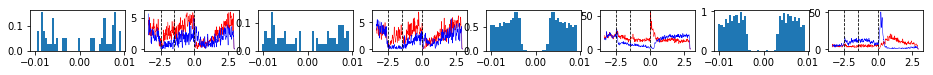

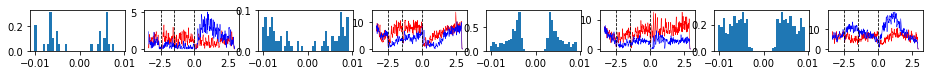

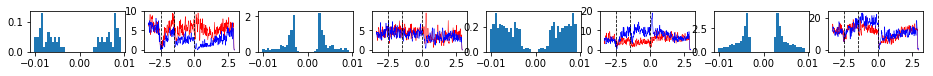

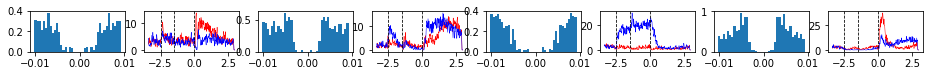

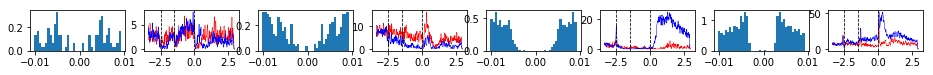

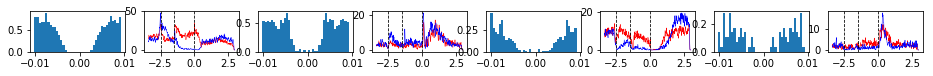

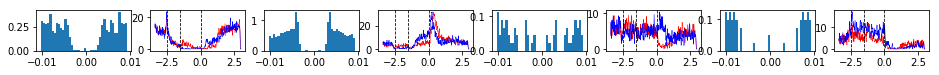

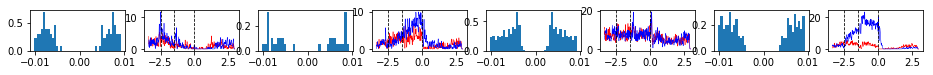

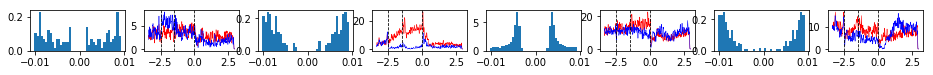

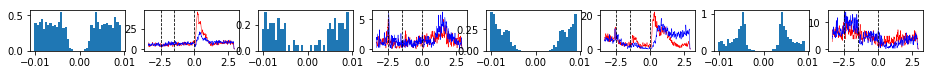

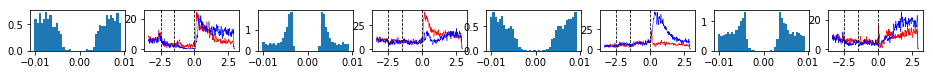

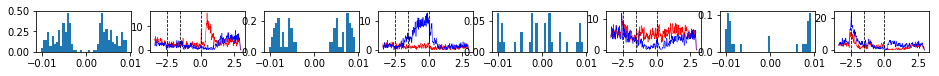

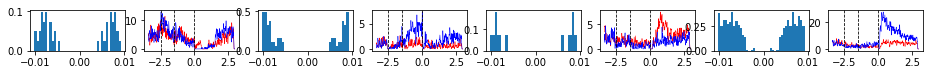

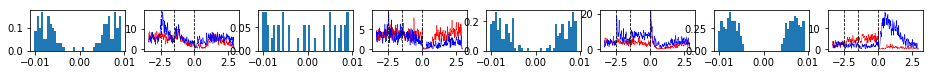

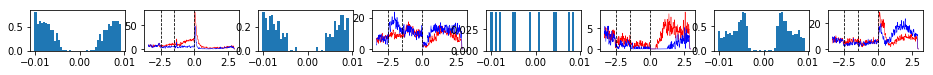

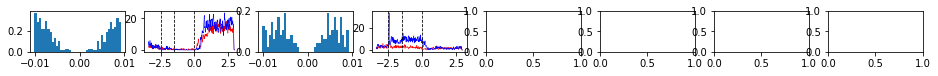

In [16]:
for psth_chunks in  split_list(lh_PTupper_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.75))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])

### Extended Data Fig5b - PT<sub>lower</sub> - Left ALM

Calling the `plot_psth_isi()` function for only Left ALM PT<sub>lower</sub> neurons

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


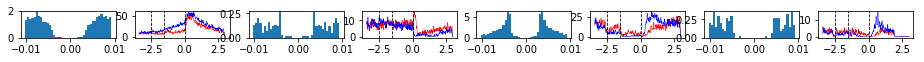

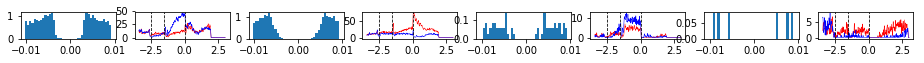

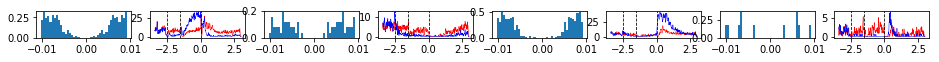

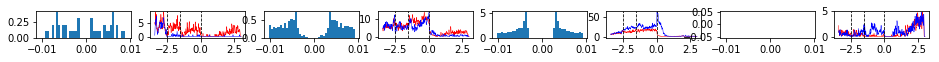

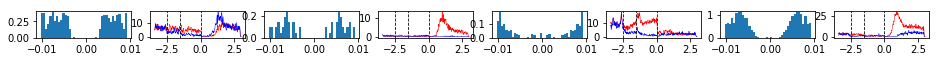

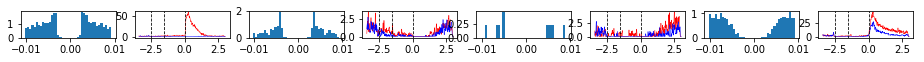

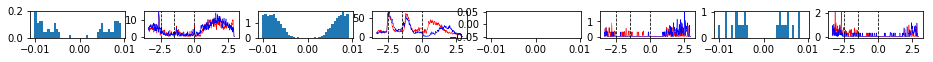

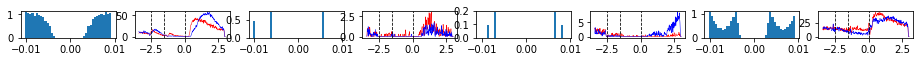

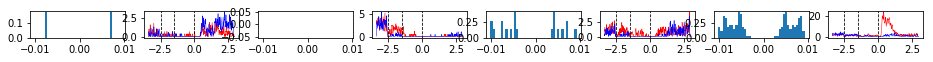

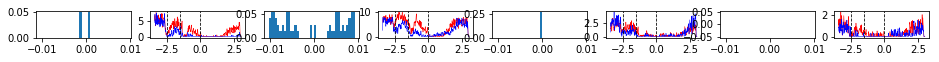

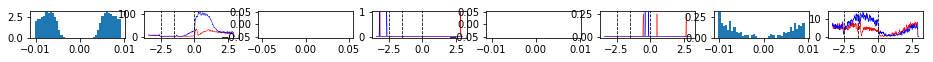

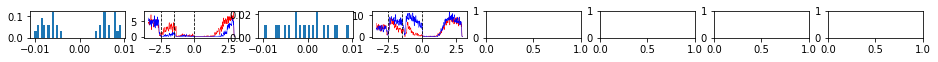

In [17]:
for psth_chunks in  split_list(lh_PTlower_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.5))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])

### Extended Data Fig5b - PT<sub>lower</sub> - Right ALM
Calling the `plot_psth_isi()` function for only Right ALM PT<sub>lower</sub> neurons

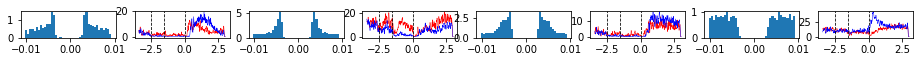

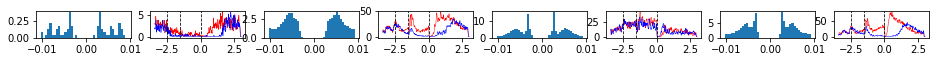

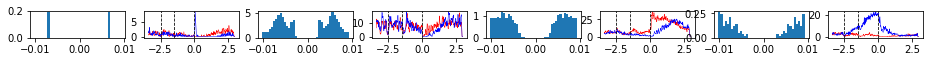

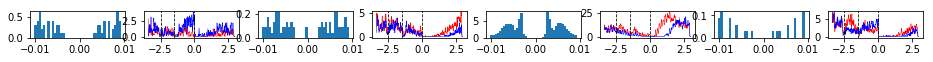

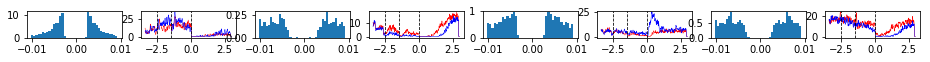

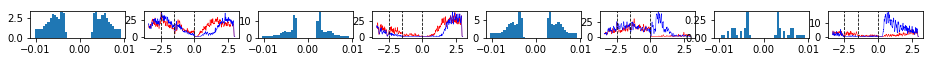

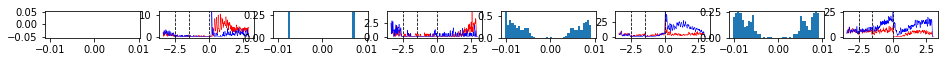

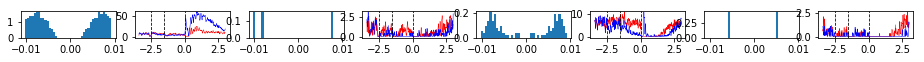

In [18]:
for psth_chunks in  split_list(rh_PTlower_units_psth, 4):
    fig, axes = plt.subplots(1, 8, figsize=(16, 0.5))
    for idx, isi_psth_dict in enumerate(psth_chunks):
        plot_psth_isi(isi_psth_dict, axes[idx*2:idx*2+2])